# Clasificacion de instancias del problema de la mochila

Empezamos importando todas las librerias que vamos a usar

In [54]:
import pylab as pl
import pandas as pd
from sklearn.manifold import Isomap
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split
import numpy as np
from os import listdir, walk
from os.path import isfile, join
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

Ahora definimos las etiquetas de cada tipo de instancia y los directorios en los que las podemos encontrar. Estamos usando únicamente instancias de 50 elementos.

In [55]:
UNCORRELATED = 0
WEAKLY = 1
STRONGLY = 2
INVERSE = 3
ALMOST_STRONG = 4
SUBSET_SUM = 5
UNCORRELATED_WITH_SIMILAR = 6
SPANNER_UNCORRELATED = 7
SPANNER_WEAKLY_CORRELATED = 8
SPANNER_STRONGLY_CORRELATED = 9
MULTIPLE_STRONGLY_CORRELATED = 10
PROFIT_CEILING = 11
CIRLE = 12

uncorrelated = "../00Uncorrelated/n00050/R01000"
weakly_correlated = "../01WeaklyCorrelated/n00050/R01000"
strongly_correlated = "../02StronglyCorrelated/n00050/R01000"
inverse_strongly_correlated = "../03InverseStronglyCorrelated/n00050/R01000"
almost_strongly_correlated = "../04AlmostStronglyCorrelated/n00050/R01000"
subset_sum_correlated = "../05SubsetSum/n00050/R01000"
uncorrelated_with_similar_w = "../06UncorrelatedWithSimilarWeights/n00050/R01000"
spanner_uncorrelated_p = "../07SpannerUncorrelated/n00050/R01000"
spanner_weakly_c = "../08SpannerWeaklyCorrelated/n00050/R01000"
spanner_strong = "../09SpannerStronglyCorrelated/n00050/R01000"
multiple_strong = "../10MultipleStronglyCorrelated/n00050/R01000"
profit = "../11ProfitCeiling/n00050/R01000"
circle_p = "../12Circle/n00050/R01000"

A continuación, una función para extraer el contenido de estos ficheros. Como variables vamos a escoger: el tamaño de la instancia, la capacidad de la mochila, la relación beneficio/peso, suma de peso y suma de beneficio.

In [56]:
def read_data(paths, targets):
    list_of_data = []
    for path, target in zip(paths, targets):
        #print(f"{path} --> {target}")
        # Leemos los ficheros disponibles
        filenames = [join(path, file)
                     for file in listdir(path) if isfile(join(path, file))]
        #print(f"Found {len(filenames)} filenames")
        # Leemos los datos de cada fichero
        for filename in filenames:
            data = {}
            with open(filename) as file:
                data_file = [line.split()
                             for line in file if len(line.split()) >= 1]
                # Cogemos el numero de elementos
                data["num"] = int(data_file[0][0])
                data["capacity"] = float(data_file[1][0])
                data["target"] = target
                weights_and_profits = np.asfarray(data_file[2:])
                sum_w_p = np.sum(weights_and_profits, axis=0)
                # Dividimos la suma de los beneficios entre la suma de los pesos
                data["relation"] = sum_w_p[1] / sum_w_p[0]
                data["sum_w"] = sum_w_p[0]
                data["sum_p"] = sum_w_p[1]
            list_of_data.append(data)
    # Creamos un dataframe con la lista de elementos
    # En la lista, cada elemento es un diccionario que contiene
    # - Numero de elementos
    # - Capacidad de la mochila
    # - Relacion
    # - Target
    dataframe = pd.DataFrame(list_of_data)
    return dataframe


Para crear el conjunto de datos usamos un metodo que carga todos los ficheros y procesa la salida.

In [57]:
def create_dataset():
    # Primero leemos los datos y les asignamos las etiquetas
    paths = [uncorrelated, weakly_correlated, strongly_correlated, 
             inverse_strongly_correlated, almost_strongly_correlated, 
             subset_sum_correlated, uncorrelated_with_similar_w,
             spanner_uncorrelated_p, spanner_weakly_c, spanner_strong, 
             multiple_strong, profit, circle_p]

    targets = [UNCORRELATED, WEAKLY, STRONGLY, INVERSE, ALMOST_STRONG, 
               SUBSET_SUM, UNCORRELATED_WITH_SIMILAR, SPANNER_UNCORRELATED, 
               SPANNER_WEAKLY_CORRELATED, SPANNER_STRONGLY_CORRELATED, 
               MULTIPLE_STRONGLY_CORRELATED, PROFIT_CEILING, CIRLE]
    dataframe = read_data(paths, targets)
    # Mostramos algunas filas del conjunto
    print(dataset.head())
    x_data = dataframe.drop("target", axis=1)
    y_data = dataframe["target"]
    print(f"X_data shape is {x_data.shape}\nY_data shape is {y_data.shape}")
    print(dataframe.describe())
    return x_data, y_data, dataframe

Incluimos un método auxiliar para mostrar la matriz de confusión:

In [74]:
def create_confusion_matrix(y_test, y_model, title):
    matrix = confusion_matrix(y_test, y_model)
    plt.figure(figsize=(10, 10))
    sns.heatmap(matrix, square=True, annot=True, cbar=False)
    plt.xlabel("Predicted value")
    plt.ylabel("True value")
    plt.title(title)
    plt.show()


Incluimos un método génerico para aplicar los distintos modelos y obtener los resultados del proceso

In [75]:
def apply_model(model, x_train, x_test, y_train, y_test, title):
    print(f"Applying {title} model")
    model.fit(x_train, y_train)
    # Tras entrenar el modelo pasamos al proceso de validacion
    y_predicted = model.predict(x_test)
    score = accuracy_score(y_test, y_predicted) * 100
    model_score = model.score(x_test, y_test) * 100
    train_score = model.score(x_train, y_train) * 100
    print(
        f"- Accuracy score {score}%\n- Using model.score(): {model_score}%\n- Training score: {train_score}%")
    create_confusion_matrix(y_test, y_predicted, title)
    print(
        f"Classificacion Report: \n{classification_report(y_test, y_predicted)}")
    return score, model_score, train_score

Para comparar los resultados, vamos a mostrar los resultados en porcentaje de acierto del proceso de entrenamiento y testeo para cada modelo empleado. Definimos el método "plot_train_vs_test_accuracy" para ello:

In [76]:
def plot_train_vs_test_accuracy(n, train_scores, test_scores, labels):
    fig, axis = plt.subplots(figsize=(30, 20), dpi=100)
    ind = np.arange(n)
    width = 0.35
    train_rects = axis.bar(ind, train_scores, width, color="red")
    test_rects = axis.bar(ind + width, test_scores, width, color="green")
    axis.set_ylabel("Scores")
    axis.set_title("Scores by different models")
    axis.set_xticks(ind + width / 2)
    axis.set_xticklabels(labels)
    axis.legend((train_rects[0], test_rects[0]), ("Train", "Test"))

    def autolabel(rectangles):
        for rect in rectangles:
            height = rect.get_height()
            axis.text(rect.get_x() + rect.get_width() / 2., 1.05 * height,
                      '%d' % int(height),
                      ha='center', va='bottom')

    autolabel(train_rects)
    autolabel(test_rects)
    plt.show()

Ahora solo nos queda obtener los datos, generar los conjuntos de entrenamiento y testeo y por último lanzar los modelos.

   capacity  num  relation    sum_p    sum_w  target
0   12730.0   50  1.009540  25715.0  25472.0       0
1   10843.0   50  0.895425  21903.0  24461.0       0
2   11795.0   50  0.983448  23826.0  24227.0       0
3   12638.0   50  1.161405  25530.0  21982.0       0
4   13598.0   50  1.153003  27468.0  23823.0       0
X_data shape is (1300, 5)
Y_data shape is (1300,)
           capacity     num     relation         sum_p          sum_w  \
count  1.300000e+03  1300.0  1300.000000  1.300000e+03    1300.000000   
mean   2.005873e+05    50.0    16.351750  4.051877e+05   64538.363846   
std    6.572535e+05     0.0    53.898811  1.327652e+06  133147.176996   
min    1.720000e+02    50.0     0.017748  3.480000e+02     956.000000   
25%    1.073975e+04    50.0     0.691971  2.169500e+04   23589.000000   
50%    1.208700e+04    50.0     0.938704  2.441600e+04   26359.500000   
75%    1.327500e+04    50.0     1.018023  2.681700e+04   31917.500000   
max    2.476727e+06    50.0   236.871395  5.0029

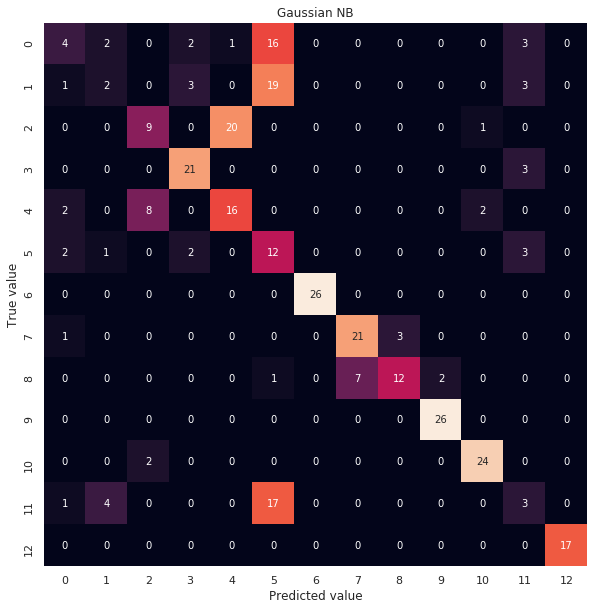

Classificacion Report: 
              precision    recall  f1-score   support

           0       0.36      0.14      0.21        28
           1       0.22      0.07      0.11        28
           2       0.47      0.30      0.37        30
           3       0.75      0.88      0.81        24
           4       0.43      0.57      0.49        28
           5       0.18      0.60      0.28        20
           6       1.00      1.00      1.00        26
           7       0.75      0.84      0.79        25
           8       0.80      0.55      0.65        22
           9       0.93      1.00      0.96        26
          10       0.89      0.92      0.91        26
          11       0.20      0.12      0.15        25
          12       1.00      1.00      1.00        17

   micro avg       0.59      0.59      0.59       325
   macro avg       0.61      0.61      0.59       325
weighted avg       0.60      0.59      0.58       325

Applying Decision Tree model
- Accuracy score 76.615384

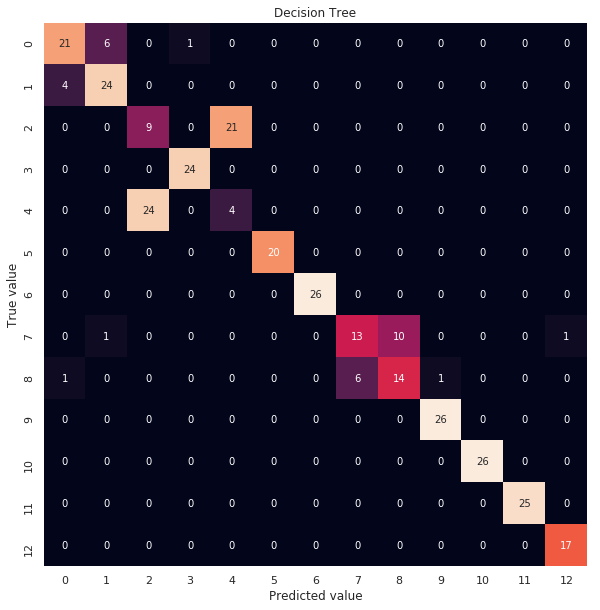

Classificacion Report: 
              precision    recall  f1-score   support

           0       0.81      0.75      0.78        28
           1       0.77      0.86      0.81        28
           2       0.27      0.30      0.29        30
           3       0.96      1.00      0.98        24
           4       0.16      0.14      0.15        28
           5       1.00      1.00      1.00        20
           6       1.00      1.00      1.00        26
           7       0.68      0.52      0.59        25
           8       0.58      0.64      0.61        22
           9       0.96      1.00      0.98        26
          10       1.00      1.00      1.00        26
          11       1.00      1.00      1.00        25
          12       0.94      1.00      0.97        17

   micro avg       0.77      0.77      0.77       325
   macro avg       0.78      0.79      0.78       325
weighted avg       0.76      0.77      0.76       325

Applying KNN-1 model
- Accuracy score 63.69230769230769

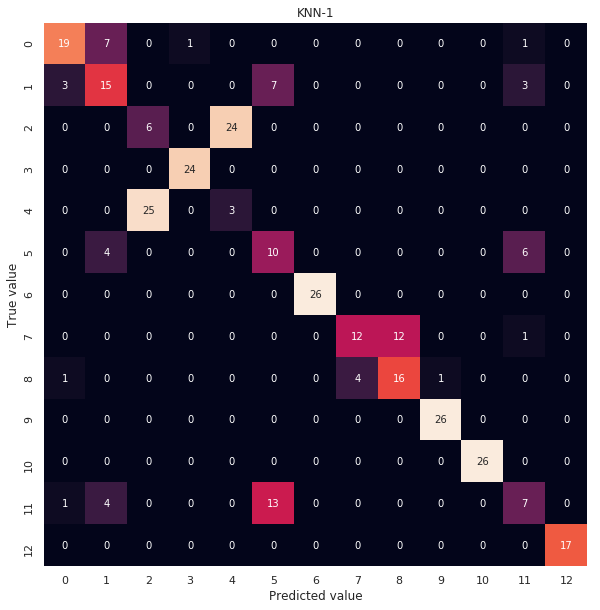

Classificacion Report: 
              precision    recall  f1-score   support

           0       0.79      0.68      0.73        28
           1       0.50      0.54      0.52        28
           2       0.19      0.20      0.20        30
           3       0.96      1.00      0.98        24
           4       0.11      0.11      0.11        28
           5       0.33      0.50      0.40        20
           6       1.00      1.00      1.00        26
           7       0.75      0.48      0.59        25
           8       0.57      0.73      0.64        22
           9       0.96      1.00      0.98        26
          10       1.00      1.00      1.00        26
          11       0.39      0.28      0.33        25
          12       1.00      1.00      1.00        17

   micro avg       0.64      0.64      0.64       325
   macro avg       0.66      0.65      0.65       325
weighted avg       0.65      0.64      0.64       325

Applying KNN-2 model
- Accuracy score 68.92307692307692

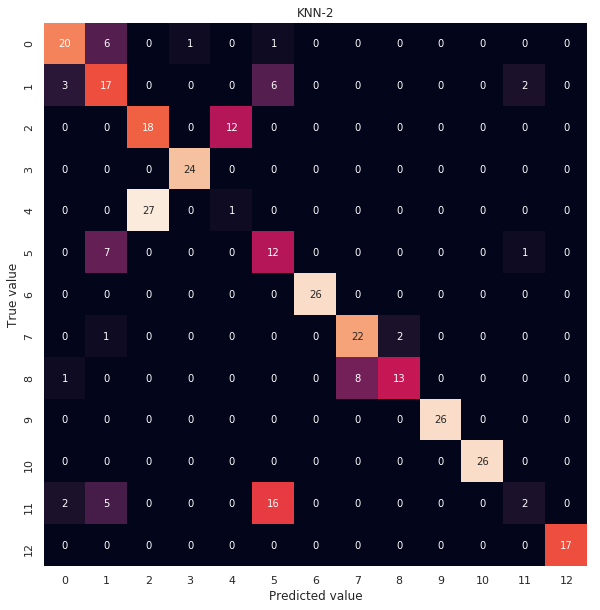

Classificacion Report: 
              precision    recall  f1-score   support

           0       0.77      0.71      0.74        28
           1       0.47      0.61      0.53        28
           2       0.40      0.60      0.48        30
           3       0.96      1.00      0.98        24
           4       0.08      0.04      0.05        28
           5       0.34      0.60      0.44        20
           6       1.00      1.00      1.00        26
           7       0.73      0.88      0.80        25
           8       0.87      0.59      0.70        22
           9       1.00      1.00      1.00        26
          10       1.00      1.00      1.00        26
          11       0.40      0.08      0.13        25
          12       1.00      1.00      1.00        17

   micro avg       0.69      0.69      0.69       325
   macro avg       0.69      0.70      0.68       325
weighted avg       0.68      0.69      0.67       325

Applying KNN-3 model
- Accuracy score 61.53846153846154

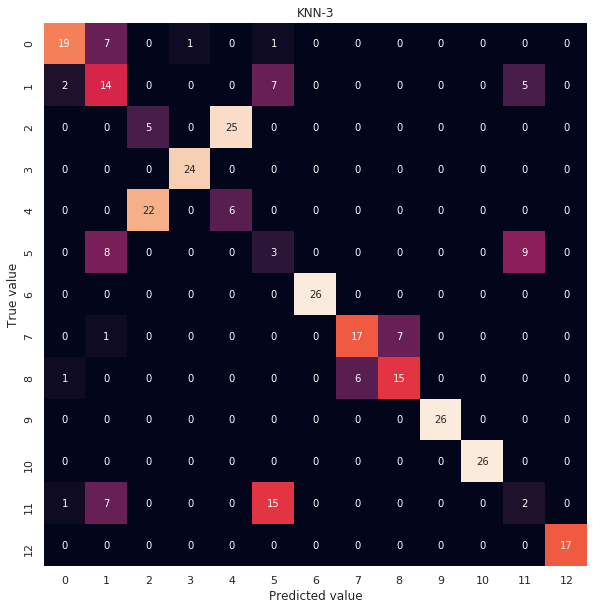

Classificacion Report: 
              precision    recall  f1-score   support

           0       0.83      0.68      0.75        28
           1       0.38      0.50      0.43        28
           2       0.19      0.17      0.18        30
           3       0.96      1.00      0.98        24
           4       0.19      0.21      0.20        28
           5       0.12      0.15      0.13        20
           6       1.00      1.00      1.00        26
           7       0.74      0.68      0.71        25
           8       0.68      0.68      0.68        22
           9       1.00      1.00      1.00        26
          10       1.00      1.00      1.00        26
          11       0.12      0.08      0.10        25
          12       1.00      1.00      1.00        17

   micro avg       0.62      0.62      0.62       325
   macro avg       0.63      0.63      0.63       325
weighted avg       0.62      0.62      0.62       325

Applying KNN-4 model
- Accuracy score 63.69230769230769

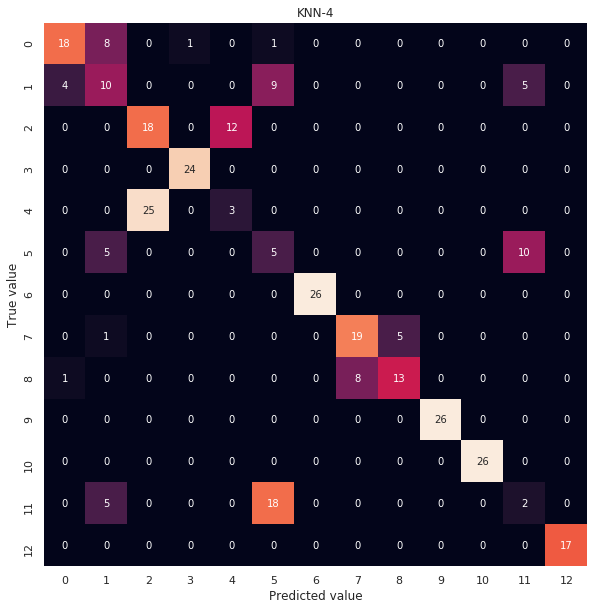

Classificacion Report: 
              precision    recall  f1-score   support

           0       0.78      0.64      0.71        28
           1       0.34      0.36      0.35        28
           2       0.42      0.60      0.49        30
           3       0.96      1.00      0.98        24
           4       0.20      0.11      0.14        28
           5       0.15      0.25      0.19        20
           6       1.00      1.00      1.00        26
           7       0.70      0.76      0.73        25
           8       0.72      0.59      0.65        22
           9       1.00      1.00      1.00        26
          10       1.00      1.00      1.00        26
          11       0.12      0.08      0.10        25
          12       1.00      1.00      1.00        17

   micro avg       0.64      0.64      0.64       325
   macro avg       0.65      0.65      0.64       325
weighted avg       0.64      0.64      0.63       325

Applying KNN-5 model
- Accuracy score 60.30769230769231

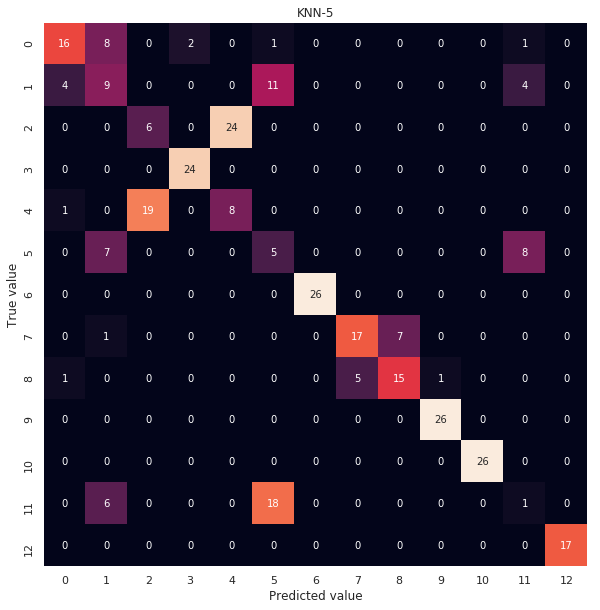

Classificacion Report: 
              precision    recall  f1-score   support

           0       0.73      0.57      0.64        28
           1       0.29      0.32      0.31        28
           2       0.24      0.20      0.22        30
           3       0.92      1.00      0.96        24
           4       0.25      0.29      0.27        28
           5       0.14      0.25      0.18        20
           6       1.00      1.00      1.00        26
           7       0.77      0.68      0.72        25
           8       0.68      0.68      0.68        22
           9       0.96      1.00      0.98        26
          10       1.00      1.00      1.00        26
          11       0.07      0.04      0.05        25
          12       1.00      1.00      1.00        17

   micro avg       0.60      0.60      0.60       325
   macro avg       0.62      0.62      0.62       325
weighted avg       0.61      0.60      0.60       325

Applying KNN-6 model
- Accuracy score 62.46153846153846

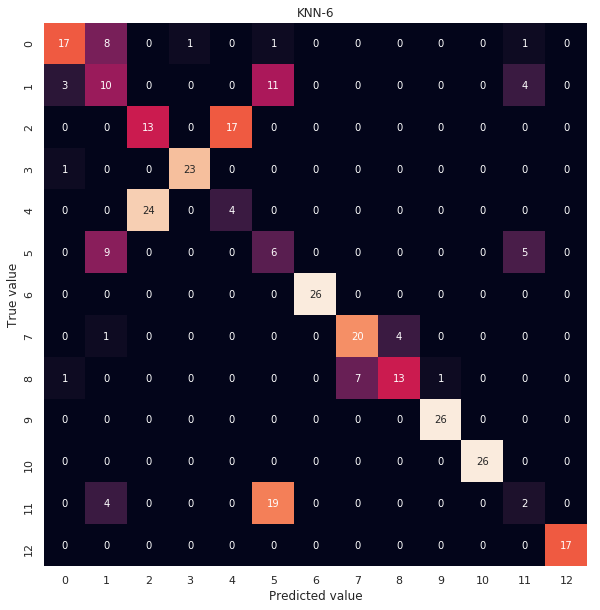

Classificacion Report: 
              precision    recall  f1-score   support

           0       0.77      0.61      0.68        28
           1       0.31      0.36      0.33        28
           2       0.35      0.43      0.39        30
           3       0.96      0.96      0.96        24
           4       0.19      0.14      0.16        28
           5       0.16      0.30      0.21        20
           6       1.00      1.00      1.00        26
           7       0.74      0.80      0.77        25
           8       0.76      0.59      0.67        22
           9       0.96      1.00      0.98        26
          10       1.00      1.00      1.00        26
          11       0.17      0.08      0.11        25
          12       1.00      1.00      1.00        17

   micro avg       0.62      0.62      0.62       325
   macro avg       0.64      0.64      0.64       325
weighted avg       0.63      0.62      0.62       325

Applying KNN-7 model
- Accuracy score 60.0%
- Using mod

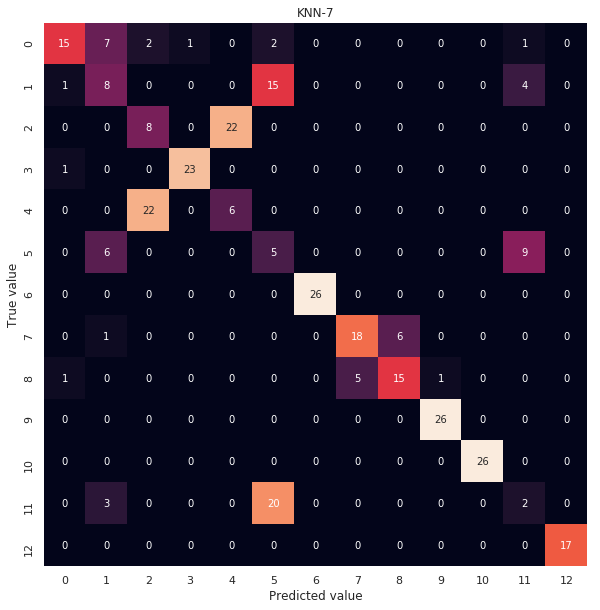

Classificacion Report: 
              precision    recall  f1-score   support

           0       0.83      0.54      0.65        28
           1       0.32      0.29      0.30        28
           2       0.25      0.27      0.26        30
           3       0.96      0.96      0.96        24
           4       0.21      0.21      0.21        28
           5       0.12      0.25      0.16        20
           6       1.00      1.00      1.00        26
           7       0.78      0.72      0.75        25
           8       0.71      0.68      0.70        22
           9       0.96      1.00      0.98        26
          10       1.00      1.00      1.00        26
          11       0.12      0.08      0.10        25
          12       1.00      1.00      1.00        17

   micro avg       0.60      0.60      0.60       325
   macro avg       0.64      0.61      0.62       325
weighted avg       0.63      0.60      0.61       325

Applying KNN-8 model
- Accuracy score 63.07692307692307

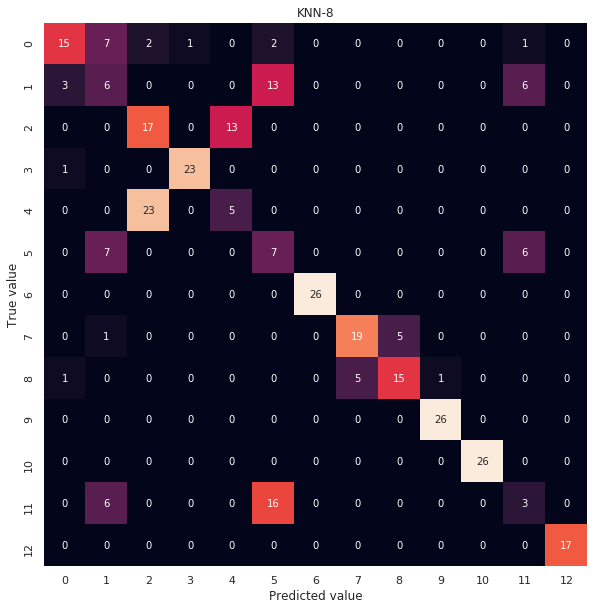

Classificacion Report: 
              precision    recall  f1-score   support

           0       0.75      0.54      0.63        28
           1       0.22      0.21      0.22        28
           2       0.40      0.57      0.47        30
           3       0.96      0.96      0.96        24
           4       0.28      0.18      0.22        28
           5       0.18      0.35      0.24        20
           6       1.00      1.00      1.00        26
           7       0.79      0.76      0.78        25
           8       0.75      0.68      0.71        22
           9       0.96      1.00      0.98        26
          10       1.00      1.00      1.00        26
          11       0.19      0.12      0.15        25
          12       1.00      1.00      1.00        17

   micro avg       0.63      0.63      0.63       325
   macro avg       0.65      0.64      0.64       325
weighted avg       0.64      0.63      0.63       325

Applying KNN-9 model
- Accuracy score 63.38461538461539

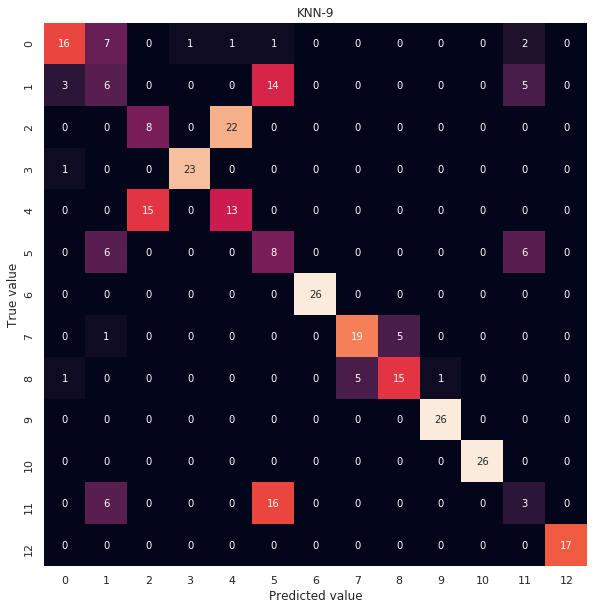

Classificacion Report: 
              precision    recall  f1-score   support

           0       0.76      0.57      0.65        28
           1       0.23      0.21      0.22        28
           2       0.35      0.27      0.30        30
           3       0.96      0.96      0.96        24
           4       0.36      0.46      0.41        28
           5       0.21      0.40      0.27        20
           6       1.00      1.00      1.00        26
           7       0.79      0.76      0.78        25
           8       0.75      0.68      0.71        22
           9       0.96      1.00      0.98        26
          10       1.00      1.00      1.00        26
          11       0.19      0.12      0.15        25
          12       1.00      1.00      1.00        17

   micro avg       0.63      0.63      0.63       325
   macro avg       0.66      0.65      0.65       325
weighted avg       0.65      0.63      0.64       325

Applying KNN-10 model
- Accuracy score 63.0769230769230

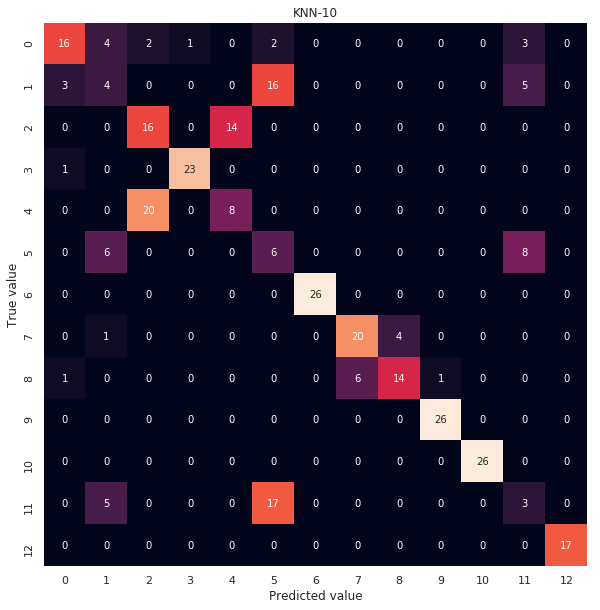

Classificacion Report: 
              precision    recall  f1-score   support

           0       0.76      0.57      0.65        28
           1       0.20      0.14      0.17        28
           2       0.42      0.53      0.47        30
           3       0.96      0.96      0.96        24
           4       0.36      0.29      0.32        28
           5       0.15      0.30      0.20        20
           6       1.00      1.00      1.00        26
           7       0.77      0.80      0.78        25
           8       0.78      0.64      0.70        22
           9       0.96      1.00      0.98        26
          10       1.00      1.00      1.00        26
          11       0.16      0.12      0.14        25
          12       1.00      1.00      1.00        17

   micro avg       0.63      0.63      0.63       325
   macro avg       0.66      0.64      0.64       325
weighted avg       0.65      0.63      0.63       325

Applying KNN-11 model
- Accuracy score 63.3846153846153

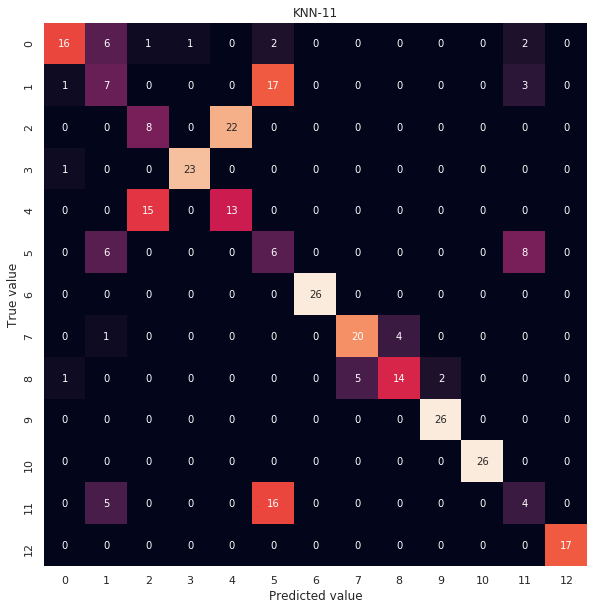

Classificacion Report: 
              precision    recall  f1-score   support

           0       0.84      0.57      0.68        28
           1       0.28      0.25      0.26        28
           2       0.33      0.27      0.30        30
           3       0.96      0.96      0.96        24
           4       0.37      0.46      0.41        28
           5       0.15      0.30      0.20        20
           6       1.00      1.00      1.00        26
           7       0.80      0.80      0.80        25
           8       0.78      0.64      0.70        22
           9       0.93      1.00      0.96        26
          10       1.00      1.00      1.00        26
          11       0.24      0.16      0.19        25
          12       1.00      1.00      1.00        17

   micro avg       0.63      0.63      0.63       325
   macro avg       0.67      0.65      0.65       325
weighted avg       0.66      0.63      0.64       325

Applying KNN-12 model
- Accuracy score 62.1538461538461

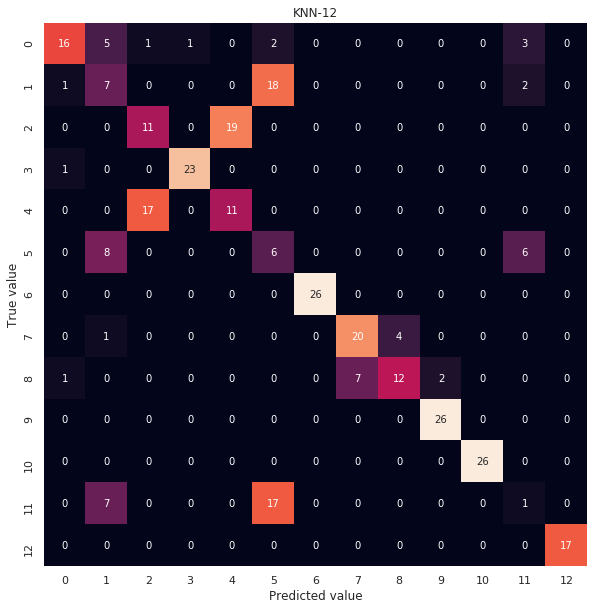

Classificacion Report: 
              precision    recall  f1-score   support

           0       0.84      0.57      0.68        28
           1       0.25      0.25      0.25        28
           2       0.38      0.37      0.37        30
           3       0.96      0.96      0.96        24
           4       0.37      0.39      0.38        28
           5       0.14      0.30      0.19        20
           6       1.00      1.00      1.00        26
           7       0.74      0.80      0.77        25
           8       0.75      0.55      0.63        22
           9       0.93      1.00      0.96        26
          10       1.00      1.00      1.00        26
          11       0.08      0.04      0.05        25
          12       1.00      1.00      1.00        17

   micro avg       0.62      0.62      0.62       325
   macro avg       0.65      0.63      0.63       325
weighted avg       0.64      0.62      0.63       325

Applying KNN-13 model
- Accuracy score 61.2307692307692

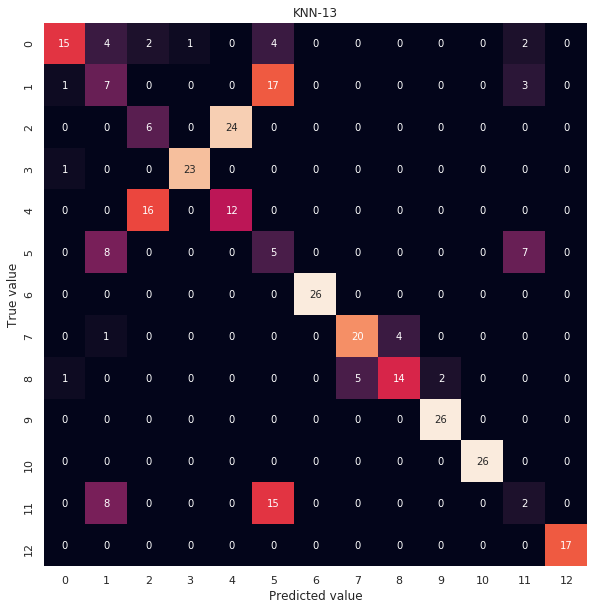

Classificacion Report: 
              precision    recall  f1-score   support

           0       0.83      0.54      0.65        28
           1       0.25      0.25      0.25        28
           2       0.25      0.20      0.22        30
           3       0.96      0.96      0.96        24
           4       0.33      0.43      0.38        28
           5       0.12      0.25      0.16        20
           6       1.00      1.00      1.00        26
           7       0.80      0.80      0.80        25
           8       0.78      0.64      0.70        22
           9       0.93      1.00      0.96        26
          10       1.00      1.00      1.00        26
          11       0.14      0.08      0.10        25
          12       1.00      1.00      1.00        17

   micro avg       0.61      0.61      0.61       325
   macro avg       0.65      0.63      0.63       325
weighted avg       0.64      0.61      0.62       325

Applying KNN-14 model
- Accuracy score 62.1538461538461

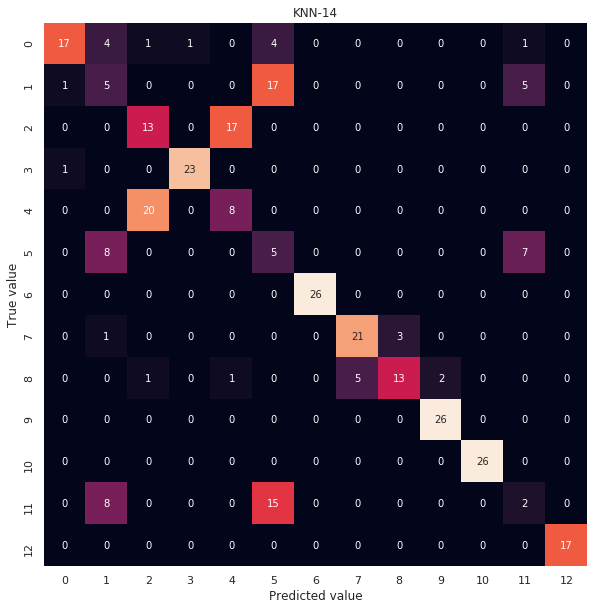

Classificacion Report: 
              precision    recall  f1-score   support

           0       0.89      0.61      0.72        28
           1       0.19      0.18      0.19        28
           2       0.37      0.43      0.40        30
           3       0.96      0.96      0.96        24
           4       0.31      0.29      0.30        28
           5       0.12      0.25      0.16        20
           6       1.00      1.00      1.00        26
           7       0.81      0.84      0.82        25
           8       0.81      0.59      0.68        22
           9       0.93      1.00      0.96        26
          10       1.00      1.00      1.00        26
          11       0.13      0.08      0.10        25
          12       1.00      1.00      1.00        17

   micro avg       0.62      0.62      0.62       325
   macro avg       0.66      0.63      0.64       325
weighted avg       0.65      0.62      0.63       325

Applying KNN-15 model
- Accuracy score 61.2307692307692

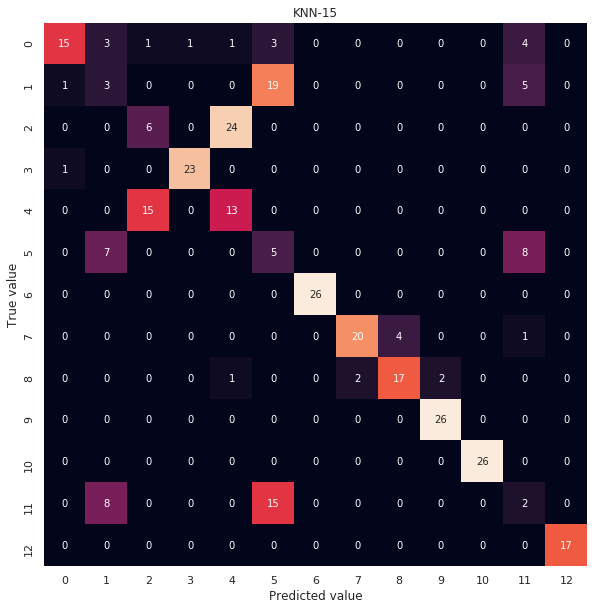

Classificacion Report: 
              precision    recall  f1-score   support

           0       0.88      0.54      0.67        28
           1       0.14      0.11      0.12        28
           2       0.27      0.20      0.23        30
           3       0.96      0.96      0.96        24
           4       0.33      0.46      0.39        28
           5       0.12      0.25      0.16        20
           6       1.00      1.00      1.00        26
           7       0.91      0.80      0.85        25
           8       0.81      0.77      0.79        22
           9       0.93      1.00      0.96        26
          10       1.00      1.00      1.00        26
          11       0.10      0.08      0.09        25
          12       1.00      1.00      1.00        17

   micro avg       0.61      0.61      0.61       325
   macro avg       0.65      0.63      0.63       325
weighted avg       0.64      0.61      0.62       325

Applying KNN-16 model
- Accuracy score 62.7692307692307

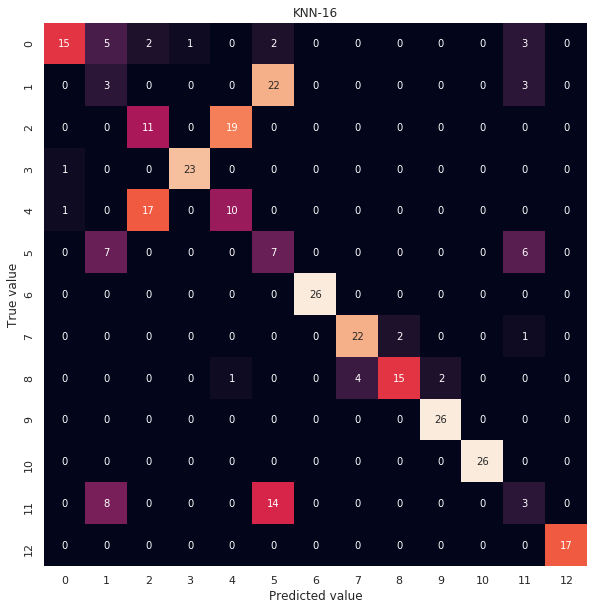

Classificacion Report: 
              precision    recall  f1-score   support

           0       0.88      0.54      0.67        28
           1       0.13      0.11      0.12        28
           2       0.37      0.37      0.37        30
           3       0.96      0.96      0.96        24
           4       0.33      0.36      0.34        28
           5       0.16      0.35      0.22        20
           6       1.00      1.00      1.00        26
           7       0.85      0.88      0.86        25
           8       0.88      0.68      0.77        22
           9       0.93      1.00      0.96        26
          10       1.00      1.00      1.00        26
          11       0.19      0.12      0.15        25
          12       1.00      1.00      1.00        17

   micro avg       0.63      0.63      0.63       325
   macro avg       0.67      0.64      0.65       325
weighted avg       0.66      0.63      0.63       325

Applying KNN-17 model
- Accuracy score 61.8461538461538

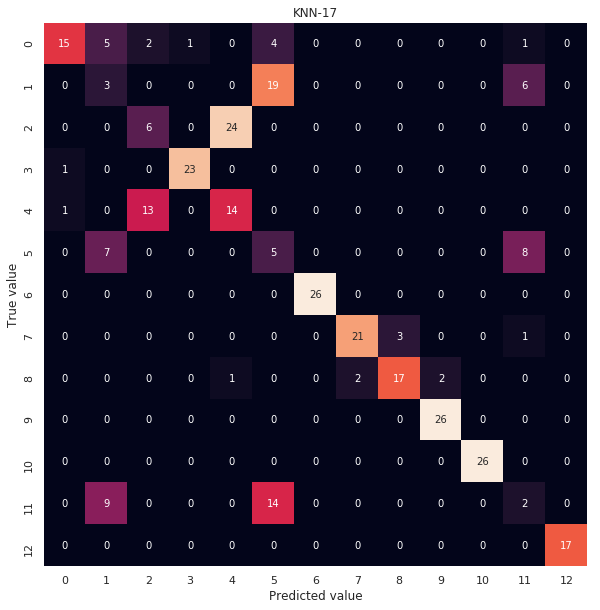

Classificacion Report: 
              precision    recall  f1-score   support

           0       0.88      0.54      0.67        28
           1       0.12      0.11      0.12        28
           2       0.29      0.20      0.24        30
           3       0.96      0.96      0.96        24
           4       0.36      0.50      0.42        28
           5       0.12      0.25      0.16        20
           6       1.00      1.00      1.00        26
           7       0.91      0.84      0.87        25
           8       0.85      0.77      0.81        22
           9       0.93      1.00      0.96        26
          10       1.00      1.00      1.00        26
          11       0.11      0.08      0.09        25
          12       1.00      1.00      1.00        17

   micro avg       0.62      0.62      0.62       325
   macro avg       0.66      0.63      0.64       325
weighted avg       0.65      0.62      0.62       325

Applying KNN-18 model
- Accuracy score 62.4615384615384

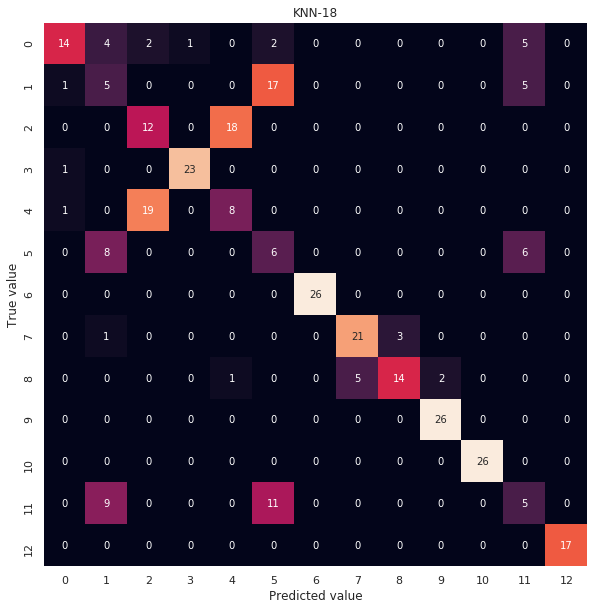

Classificacion Report: 
              precision    recall  f1-score   support

           0       0.82      0.50      0.62        28
           1       0.19      0.18      0.18        28
           2       0.36      0.40      0.38        30
           3       0.96      0.96      0.96        24
           4       0.30      0.29      0.29        28
           5       0.17      0.30      0.21        20
           6       1.00      1.00      1.00        26
           7       0.81      0.84      0.82        25
           8       0.82      0.64      0.72        22
           9       0.93      1.00      0.96        26
          10       1.00      1.00      1.00        26
          11       0.24      0.20      0.22        25
          12       1.00      1.00      1.00        17

   micro avg       0.62      0.62      0.62       325
   macro avg       0.66      0.64      0.64       325
weighted avg       0.65      0.62      0.63       325

Applying KNN-19 model
- Accuracy score 61.8461538461538

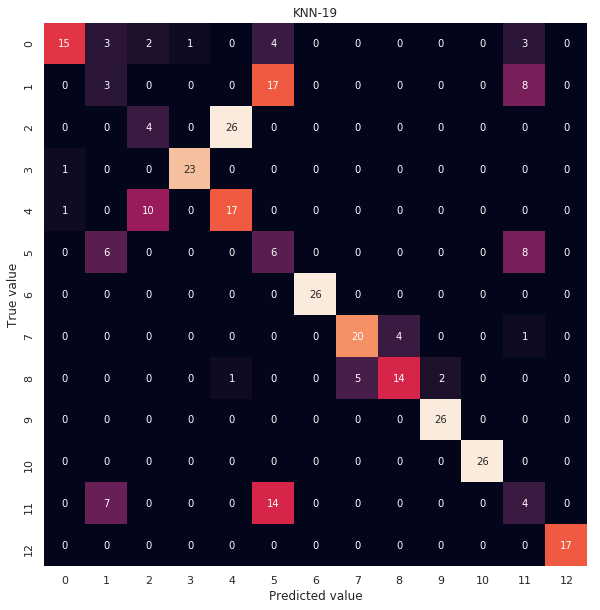

Classificacion Report: 
              precision    recall  f1-score   support

           0       0.88      0.54      0.67        28
           1       0.16      0.11      0.13        28
           2       0.25      0.13      0.17        30
           3       0.96      0.96      0.96        24
           4       0.39      0.61      0.47        28
           5       0.15      0.30      0.20        20
           6       1.00      1.00      1.00        26
           7       0.80      0.80      0.80        25
           8       0.78      0.64      0.70        22
           9       0.93      1.00      0.96        26
          10       1.00      1.00      1.00        26
          11       0.17      0.16      0.16        25
          12       1.00      1.00      1.00        17

   micro avg       0.62      0.62      0.62       325
   macro avg       0.65      0.63      0.63       325
weighted avg       0.64      0.62      0.62       325



In [77]:
x_data, y_data, dataset = create_dataset()
# Dividimos los datos en dos conjuntos, entrenamiento y testeo
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, random_state=1)

# Instanciamos los modelos y los aplicamos
gaussian_model = GaussianNB()
decision_tree = DecisionTreeClassifier()

guassian_score, _, guassian_train = apply_model(gaussian_model, x_train, x_test,
                                                    y_train, y_test, "Gaussian NB")
tree_score, _, tree_train = apply_model(decision_tree, x_train, x_test,
                                            y_train, y_test, "Decision Tree")

# Creamos los arrays con los resultados para luego hacer las graficas
train_scores = [guassian_train, tree_train]
test_scores = [guassian_score, tree_score]
    
# Variamos el parametro K del KNN para comparar resultados
k_parameters = range(1, 20)
labels = ["GNB", "DTree"]
    
for k in k_parameters:
    label = f"KNN-{k}"
    labels.append(label)
    knn_model = KNeighborsClassifier(n_neighbors=k, n_jobs=5)
    score, model, train = apply_model(knn_model, x_train, x_test, 
                                      y_train, y_test, label)
    test_scores.append(score)
    train_scores.append(train)


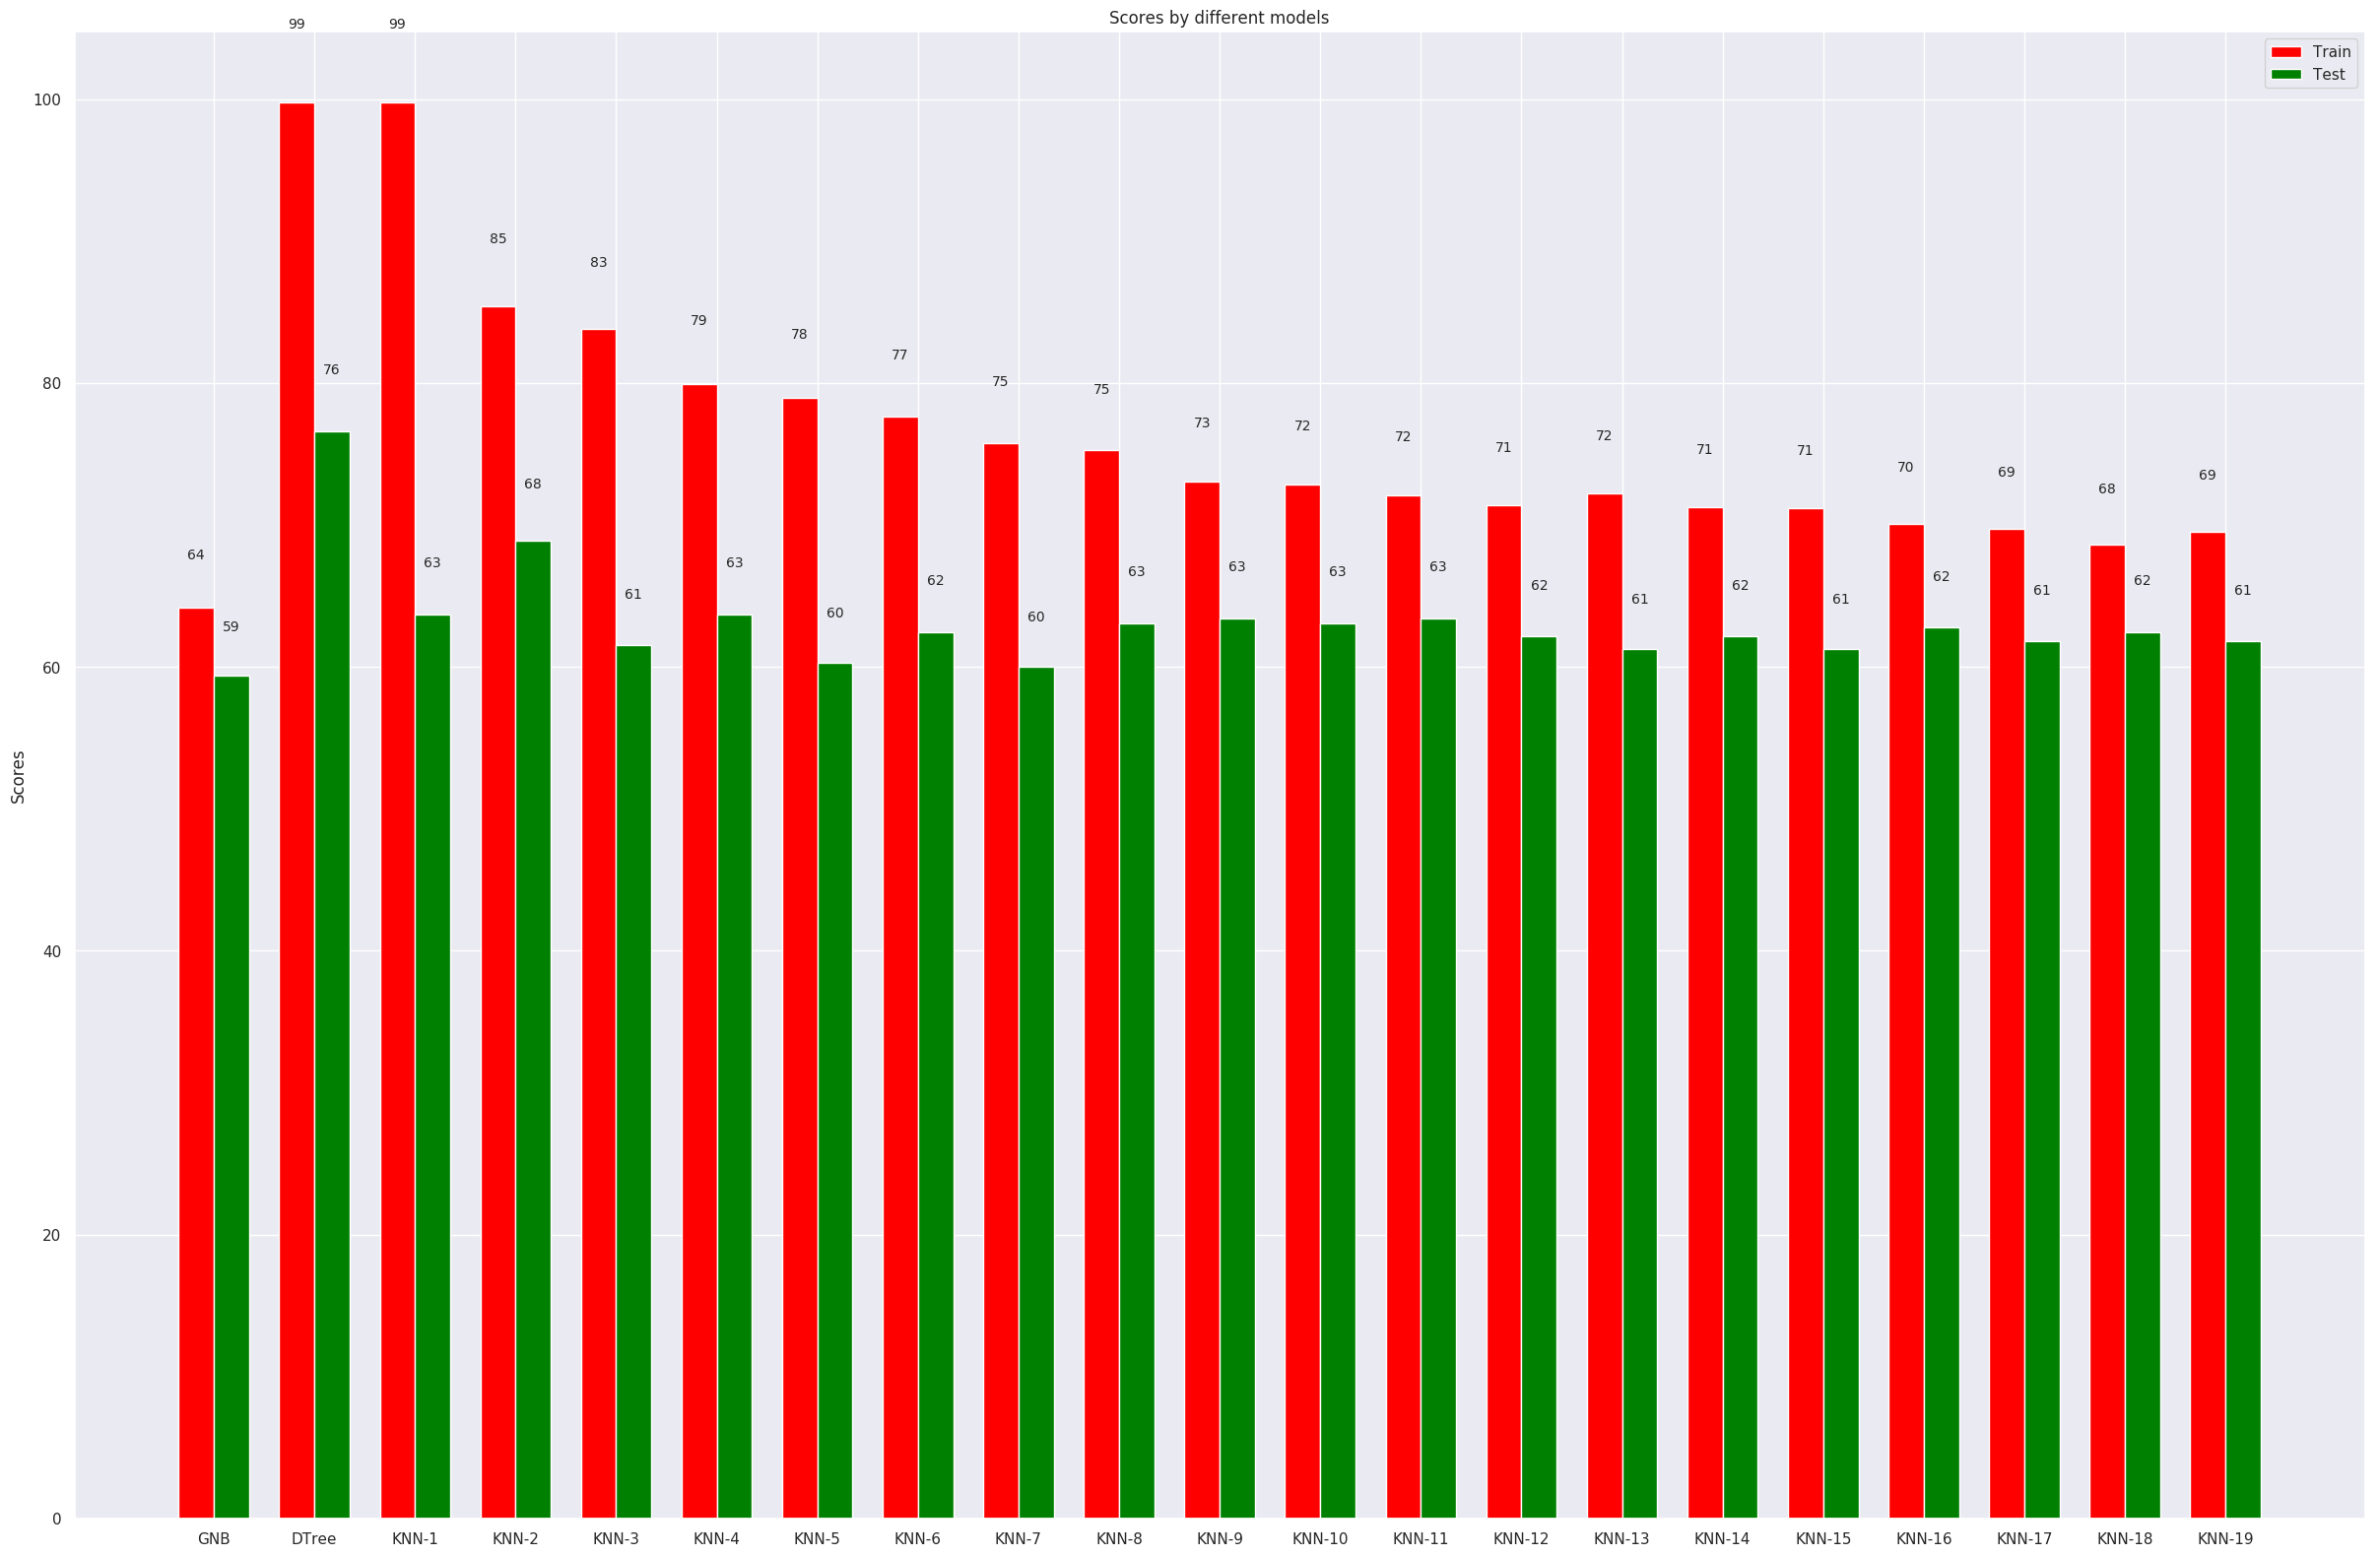

In [78]:
# Mostramos una comparacion de resultados
plot_train_vs_test_accuracy(len(labels), train_scores, test_scores, labels)